# SVD-based Agent with LogReg on Bandit Feedback

Up until now, we have primarily focused on:
- The differences between organic and bandit feedback, and how to properly exploit these signals for model evaluation
- Building a model either entirely off of either organic, or bandit feedback
- Feature engineering methods in combination with Logistic Regression to properly predict clicks

However, we haven't yet looked into combining the organic and the bandit signal to get the best of both worlds.
In this notebook, we show a simple example that combines an embedding-based approach (SVD) on the organic signal, with a simple Logistic Regression-based model that predicts whether a given user will interact with a recommendation, should we show it.
In conclusion, we show that properly combining these different types of feedback yields a significant gain in model accuracy.

## Environment Setup

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.random.mtrand import RandomState
from reco_gym import Configuration
from agents import Agent
from scipy.special import logsumexp
import pandas as pd
from scipy.stats.distributions import beta
from copy import deepcopy
from agents import OrganicUserEventCounterAgent, organic_user_count_args

from reco_gym.envs.observation import Observation
from agents import RandomAgent, random_args
from reco_gym import verify_agents, verify_agents_IPS
from reco_gym.evaluate_agent import plot_verify_agents, verify_agents_recall_at_k

import pylab

# from Keras
def to_categorical(y, num_classes=None, dtype='float32'):
  y = np.array(y, dtype='int')
  input_shape = y.shape
  if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
    input_shape = tuple(input_shape[:-1])
  y = y.ravel()
  if not num_classes:
    num_classes = np.max(y) + 1
  n = y.shape[0]
  categorical = np.zeros((n, num_classes), dtype=dtype)
  categorical[np.arange(n), y] = 1
  output_shape = input_shape + (num_classes,)
  categorical = np.reshape(categorical, output_shape)
  return categorical



import gym, reco_gym
import numpy as np
# env_0_args is a dictionary of default parameters (i.e. number of products)
from reco_gym import env_1_args, Configuration

# Set style for pretty plots
plt.style.use('ggplot')

P = 16 # Number of Products
U = 5000 # Number of Users

# You can overwrite environment arguments here:
env_1_args['random_seed'] = 42
env_1_args['num_products']= P
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=8
env_1_args['sigma_mu_organic'] = 0.0
env_1_args['sigma_omega']=0
#env_1_args['normalize_beta']=True
# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

env.reset()

In [9]:
# Generate RecSys logs for U users
reco_log = env.generate_logs(U)
reco_log.head(20)

,a,c,ps,ps-a,t,u,v,z
0,NaN,NaN,NaN,None,0,0,1.0,organic
1,NaN,NaN,NaN,None,1,0,1.0,organic
2,NaN,NaN,NaN,None,2,0,6.0,organic
3,NaN,NaN,NaN,None,3,0,1.0,organic
4,NaN,NaN,NaN,None,4,0,6.0,organic
5,NaN,NaN,NaN,None,5,0,6.0,organic
6,NaN,NaN,NaN,None,6,0,1.0,organic
7,7.0,0.0,0.0625,"[0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.062...",7,0,NaN,bandit
8,14.0,0.0,0.0625,"[0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.062...",8,0,NaN,bandit
9,2.0,0.0,0.0625,"[0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.062...",9,0,NaN,bandit


## Defining the Agent

The critical part of our agent is a Logistic Regression model, that predicts whether a user will click a given recommendation, based on some features.
In what follows, we present an overview of these simple features.

- The first `K` features are the latent components representing the user state. As proposed in the well-known SVD++ approach and aligned with the previous notebooks, we decompose the item co-count matrix and represent a user with the average embedding of the items in her history.
- Following this, we embed the specific item we want to recommend as a one-hot-encoded sparse vector of length `P`.
- In order to further exploit the organic signal: we include a count of organic views for the given item in the training set, and the result of the dot-product between the user- and item-embedding.

As discussed previously, we need cross-interaction between the user- and item-features to ensure a personalised approach.
With this in mind, we take the Kronecker-product between the first `K` and last `P+2` features in order to obtain our final `KP+2` features.

We make our agent greedy, i.e. it will always take the action it deems to have the highest probability of generating a click, without any exploratory behaviour for lesser actions.

In [10]:
from collections import defaultdict
from sklearn.linear_model import LogisticRegression

def create_embeddings(reco_log, U, P, K = 5):
    organic_reco_log = reco_log[reco_log['z']=='organic']
    counts = np.zeros((U,P))

    for u in range(U):
        counts[u,:] = to_categorical(np.array(organic_reco_log[organic_reco_log['u']==u].v,dtype=int),P).sum(0)

    counts_above_zero = 1.*(counts>0) # above zero counts only
    co_counts = np.matmul(counts_above_zero.T,counts_above_zero)
    
    w , v = np.linalg.eig(co_counts)
    idx = np.argsort(w)[::-1] 
    v = np.real(v[:,idx])
    w = np.real(w[idx])

    wdash = np.zeros_like(w)

    wdash[0:K] = w[0:K]
    embeddings = np.matmul(v,np.sqrt(np.diag(wdash)))[:,0:K] # keep the non-zero components
    return embeddings

class SVDLogRegAgent(Agent):
    def __init__(self, config, reco_log, U = U, P = P, K = 5, greedy = False):
        super(SVDLogRegAgent, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        self.organic_views = np.zeros(self.config.num_products)
        assert(P >= K)
        assert(reco_log.v.max() < P)
        self.K = K
        self.history_length = 0
        self.greedy = greedy
        self.item_popularities = defaultdict(int)
        self.train(reco_log, U, P)
        
    def train(self, reco_log, U, P):
        # Generate item embeddings by SVD on item co-count matrix
        self.embeddings = create_embeddings(reco_log, U, P, self.K)
        
        # Compute item popularities
        for row in reco_log.loc[reco_log['z'] == 'organic'].itertuples():
            self.item_popularities[int(row.v)] += 1
        
        # TODO - Not entirely correct to train embeddings on future data here... Do we care?
        # Generate feature-matrix X to train on
        X = []
        y = []
        uid = 0
        uemb = np.zeros(self.K)
        ucnt = 0
        for row in reco_log.itertuples():
            # Do we have a new user?
            if row.u != uid:
                # Reset the embedding
                uid = row.u
                uemb = np.zeros(self.K)
                ucnt = 0
            # Is this an organic event?
            if row.z == 'organic':
                # Update the user embedding
                uemb += self.embeddings[int(row.v),:]
                ucnt += 1
            elif row.z == 'bandit':
                # Pad the user embedding with zeros
                #features = np.hstack((uemb,np.zeros(P)))
                # One-hot encode the item in the last P columns
                #features[self.K + int(row.a)] = 1.
                aemb = np.zeros(P + 2)
                aemb[int(row.a)] = 1.
                aemb[-2] = self.item_popularities[int(row.a)]
                dot = np.matmul(self.embeddings[int(row.a),:],uemb/ucnt)
                aemb[-1] = dot
                features = np.kron(uemb/ucnt, aemb)
                X.append(features)
                y.append(row.c)
        X = np.asarray(X)
        y = np.asarray(y)
        
        # Train Logistic Regression model
        self.model = LogisticRegression(solver = 'liblinear',
                                        #C = .25,
                                        max_iter = 200).fit(X,y)
    
    def observe(self, observation):
        for session in observation.sessions():
            self.user_embedding += self.embeddings[session['v'],:]
            self.history_length += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)

        # Generate a prediction for every possible action
        X = []
        for a in range(self.embeddings.shape[0]):
            # Pad the user embedding with zeros
            #features = np.hstack((self.user_embedding,np.zeros(self.embeddings.shape[0])))
            # One-hot encode the item in the last P columns
            #features[self.K + a] = 1.
            aemb = np.zeros(self.embeddings.shape[0] + 2)
            aemb[int(a)] = 1.
            aemb[-2] = self.item_popularities[int(a)]
            dot = np.matmul(self.embeddings[int(a),:],(self.user_embedding/self.history_length))
            aemb[-1] = dot
            features = np.kron((self.user_embedding/self.history_length), aemb)
            X.append(features)
        prob = self.model.predict_log_proba(np.asarray(X))[:,1]
        prob = np.exp(prob-logsumexp(prob))
        
        if self.greedy:
            a = np.argmax(prob)
            prob = np.zeros(prob.shape)
            prob[a] = 1.
        
        # Sample action according to probability distribution
        action = self.rng.choice(self.config.num_products, p = prob)
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_embedding = np.zeros(self.K)
        self.history_length = 0

In [11]:
organic_counter_agent = OrganicUserEventCounterAgent(Configuration({
            **organic_user_count_args,
            **env_1_args,
            'select_randomly': True,
        }))

random_args['num_products'] = P
agent_rand = RandomAgent(Configuration({**env_1_args, **random_args,}))

SVDLR = SVDLogRegAgent(Configuration(env_1_args), reco_log, U, P, 8, True)

## A/B-Test Evaluation

We evaluate our new model by simulating an A/B-test against two baselines: the random agent and the popularity based agent.
As we have seen before, although the popularity baseline is naive and simple, it is not always that trivial to beat in a first try.

In [12]:
result_AB = verify_agents(env, U, {' Random': agent_rand, 'Popularity': organic_counter_agent, 'SVD-LR': SVDLR})
result_AB

,0.025,0.500,0.975,Agent
0,0.009673,0.009979,0.010291,Random
1,0.012253,0.012597,0.012948,Popularity
2,0.013997,0.014365,0.014740,SVD-LR


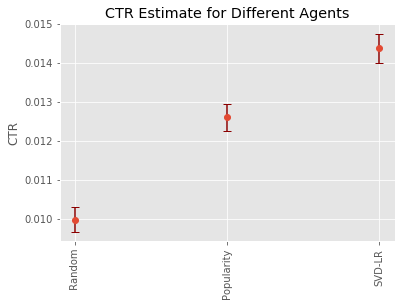

In [13]:
fig = plot_verify_agents(result_AB)
plt.ylabel('CTR')
plt.show()

On average, we see a 14% improvement in click-through rate when comparing the popularity baseline with our new SVD-LR model.
This difference might seem small, but you can imagine that a 14% increase in a million-dollar business has quite a big impact.

There are many different ways of improving upon this model, we provide some straightforward ideas:
- The embeddings currently used by the model are based on the eigen-decomposition of the co-count matrix. This approach implicitly assumes that zeroes in the matrix represent no correlation. However, this assumption often does not hold in the case of implicit-feedback datasets. More advanced matrix factorisation techniques such as WRMF, or pairwise learning procedures such as BPR might be used to further improve on the quality of the used embeddings.
- Similar in spirit to the first suggestion, more advanced models such as recurrent neural networks (RNNs) can better capture the sequential nature of the relationships among items and users. Many embedding techniques that are often used in natural language processing (e.g. BERT) can be adapted to provide meaningful latent representations in the RecSys field as well.
- More advanced classification techniques than Logistic Regression can be used to predict whether a user would or would not click on a given recommendation.
- The training data we used in this model was generated under a fully randomised logging policy, with the result that we do not have to bother about missing-not-at-random (MNAR) data. However, in real world systems, this will seldom be the case. Many so-called Batch-Learning from Bandit-Feedback (BLBF) algorithms have been proposed in recent years, that focus on exploiting propensity estimates to effectively tackle the counterfactual nature of this setting.